In [31]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [46]:
# STEP 1: Install required libraries
!pip install yfinance
!pip install tensorflow

In [47]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [48]:
# Define the stock ticker and date range
ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2024-01-01'

# Download stock data using yfinance
df = yf.download(ticker, start=start_date, end=end_date)

# Use only relevant columns
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df.dropna(inplace=True)

# Display the first few rows
df.head()


/tmp/ipython-input-3519775616.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,71.627092,72.681289,71.373218,72.620842,135480400
2020-01-03,71.847102,72.676431,71.689942,71.914803,146322800
2020-01-06,71.034709,72.526533,70.783248,72.487846,118387200
2020-01-07,72.497522,72.753816,71.926907,72.146935,108872000
2020-01-08,71.849548,73.609760,71.849548,73.307526,132079200


In [49]:
df.tail()

Price,Open,High,Low,Close,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2023-12-22,193.761066,193.989405,191.567141,192.192566,37149600
2023-12-26,192.202487,192.480450,191.428159,191.646561,28919300
2023-12-27,191.090629,192.093281,189.700797,191.745819,48087700
2023-12-28,192.728610,193.244834,191.765661,192.172684,34049900
2023-12-29,192.490361,192.986726,190.336138,191.130325,42672100


In [50]:
df.describe()

Price,Open,High,Low,Close,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,1006.000000,1006.000000,1006.000000,1006.000000,1.006000e+03
mean,138.247375,139.863375,136.743542,138.377810,9.895373e+07
std,33.453057,33.579799,33.319775,33.459341,5.439610e+07
min,55.277736,55.379527,51.528408,54.378574,2.404830e+07
25%,120.869267,122.008185,119.225828,120.763403,6.407675e+07
50%,143.100275,144.829650,141.584406,143.250961,8.467540e+07
75%,163.960279,165.974615,162.434231,163.691677,1.155069e+08
max,196.580427,198.168786,195.567834,196.669769,4.265100e+08


In [51]:
#downloded the file cvs
df.to_csv('/content/gdrive/MyDrive/data sciences project internship/stock_data.csv')

In [60]:
df = pd.read_csv("/content/gdrive/MyDrive/data sciences project internship/stock_data.csv")

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2020-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Open, AAPL)    1006 non-null   float64
 1   (High, AAPL)    1006 non-null   float64
 2   (Low, AAPL)     1006 non-null   float64
 3   (Close, AAPL)   1006 non-null   float64
 4   (Volume, AAPL)  1006 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 47.2 KB


In [53]:
df1 = df.reset_index()['Close']

In [54]:
df1

Ticker,AAPL
0,72.620842
1,71.914803
2,72.487846
3,72.146935
4,73.307526
...,...
1001,192.192566
1002,191.646561
1003,191.745819
1004,192.172684


In [55]:
print(df.columns)

MultiIndex([(  'Open', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            ( 'Close', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])


In [56]:
df.shape

(1006, 5)

In [57]:
df.isnull().sum()

,,0
Price,Ticker,
Open,AAPL,0
High,AAPL,0
Low,AAPL,0
Close,AAPL,0
Volume,AAPL,0


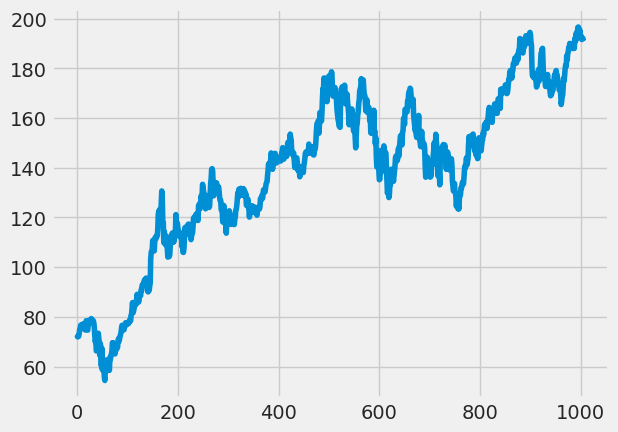

In [58]:
import matplotlib.pyplot as plt
plt.plot(df1)

### LSTM are sensitive to the scale of the data. so we apply MinMax scaler

In [59]:
#Close df1 value tranfrom 0to1
# Normalize the dataset
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [60]:
df1

array([[0.12820377],
       [0.12324184],
       [0.1272691 ],
       ...,
       [0.96539526],
       [0.96839519],
       [0.96106966]])

Step 5: Create Sequences for LSTM
We use the previous 60 days of data to predict the next day’s Close price.

In [61]:
def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i])        # Previous 60 days
        y.append(data[i, 3])                 # Index 3 = 'Close' column
    return np.array(X), np.array(y)

time_step = 60
X, y = create_sequences(scaled_data, time_step)


In [62]:
##splitting dataset into train and test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [63]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

Build and Train the LSTM Model

In [64]:
# Build LSTM model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=32))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0709 - val_loss: 0.0084
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0043 - val_loss: 0.0091
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0020 - val_loss: 0.0071
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0019 - val_loss: 0.0060
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0017 - val_loss: 0.0053
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0014 - val_loss: 0.0013


Make Predictions and Inverse Scale

In [65]:
# Predict on test data
y_pred = model.predict(X_test)

# Function to inverse transform close price
def inverse_close(y_scaled):
    dummy = np.zeros((len(y_scaled), 5))
    dummy[:, 3] = y_scaled.reshape(-1)
    return scaler.inverse_transform(dummy)[:, 3]

# Inverse scale
predicted_close = inverse_close(y_pred)
actual_close = inverse_close(y_test)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


Evaluate the Model

In [66]:
# Mean Squared Error
mse = mean_squared_error(actual_close, predicted_close)
print(f"Mean Squared Error: {mse:.4f}")


Mean Squared Error: 26.2511


Plot Actual vs Predicted Prices

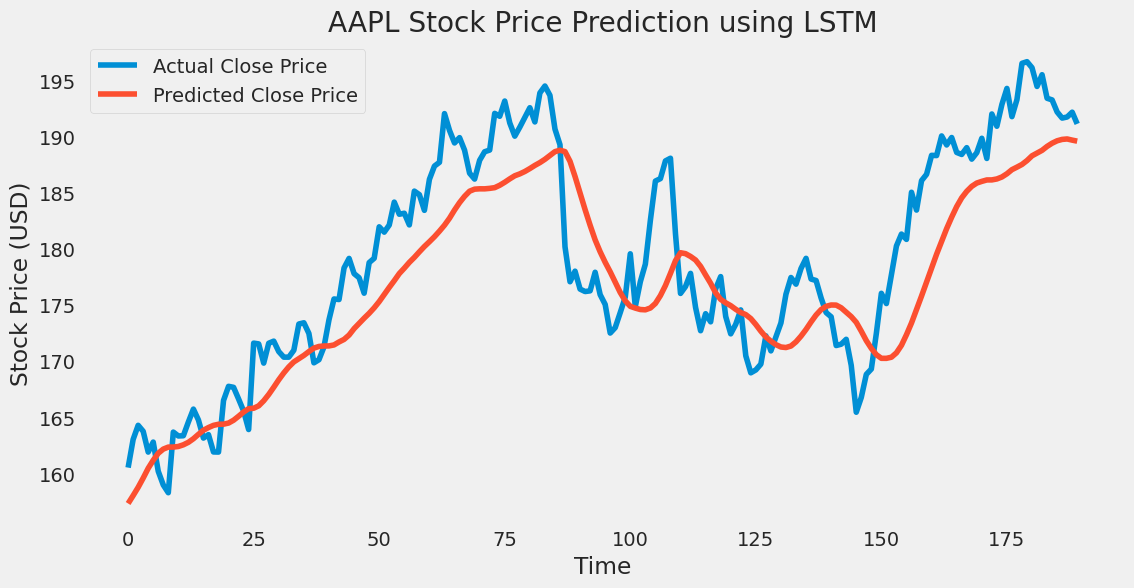

In [67]:
plt.figure(figsize=(12, 6))
plt.plot(actual_close, label='Actual Close Price')
plt.plot(predicted_close, label='Predicted Close Price')
plt.title(f"{ticker} Stock Price Prediction using LSTM")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.grid()
plt.show()


Liner Regrastion

In [68]:
# Reshape for linear regression (flatten the time steps)
nsamples, nx, ny = X_train.shape
X_train_lin = X_train.reshape((nsamples, nx*ny))

In [69]:
# Train model
lin_model = LinearRegression()
lin_model.fit(X_train_lin, y_train)

LinearRegression()

In [70]:
# Evaluate
nsamples_test, nx_test, ny_test = X_test.shape
X_test_lin = X_test.reshape((nsamples_test, nx_test*ny_test))
lin_predictions = lin_model.predict(X_test_lin)

In [71]:
# Calculate metrics
lin_mse = mean_squared_error(y_test, lin_predictions)
lin_mae = mean_absolute_error(y_test, lin_predictions)
lin_r2 = r2_score(y_test, lin_predictions)

print(f"Linear Regression Metrics:")
print(f"MSE: {lin_mse:.6f}, MAE: {lin_mae:.6f}, R2: {lin_r2:.4f}")

Linear Regression Metrics:
MSE: 0.000425, MAE: 0.016334, R2: 0.9099


LSTM Model

In [72]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [73]:
# Train model
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.1,
                    verbose=1)


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0776 - val_loss: 0.0036
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0094 - val_loss: 0.0025
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0067 - val_loss: 0.0022
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0050 - val_loss: 0.0023
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0057 - val_loss: 0.0021
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0048 - val_loss: 0.0025
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0046 - val_loss: 0.0018
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0049 - val_loss: 0.0019
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0047 - val_loss: 0.0018
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0

In [74]:
# Evaluate
lstm_predictions = model.predict(X_test)
lstm_mse = mean_squared_error(y_test, lstm_predictions)
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
lstm_r2 = r2_score(y_test, lstm_predictions)

print(f"\nLSTM Metrics:")
print(f"MSE: {lstm_mse:.6f}, MAE: {lstm_mae:.6f}, R2: {lstm_r2:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step

LSTM Metrics:
MSE: 0.002651, MAE: 0.046200, R2: 0.4387


In [75]:
def inverse_transform_predictions(scaler, data, predictions, feature_index=3):
    # Create dummy array with same shape
    dummy = np.zeros(shape=(len(predictions), data.shape[1]))
    # Place predictions in the right column
    dummy[:, feature_index] = predictions.flatten()
    # Inverse transform
    inverted = scaler.inverse_transform(dummy)
    return inverted[:, feature_index]

# Inverse transform all data
y_test_actual = inverse_transform_predictions(scaler, X_test[-1], y_test)
lin_pred_actual = inverse_transform_predictions(scaler, X_test[-1], lin_predictions)
lstm_pred_actual = inverse_transform_predictions(scaler, X_test[-1], lstm_predictions)



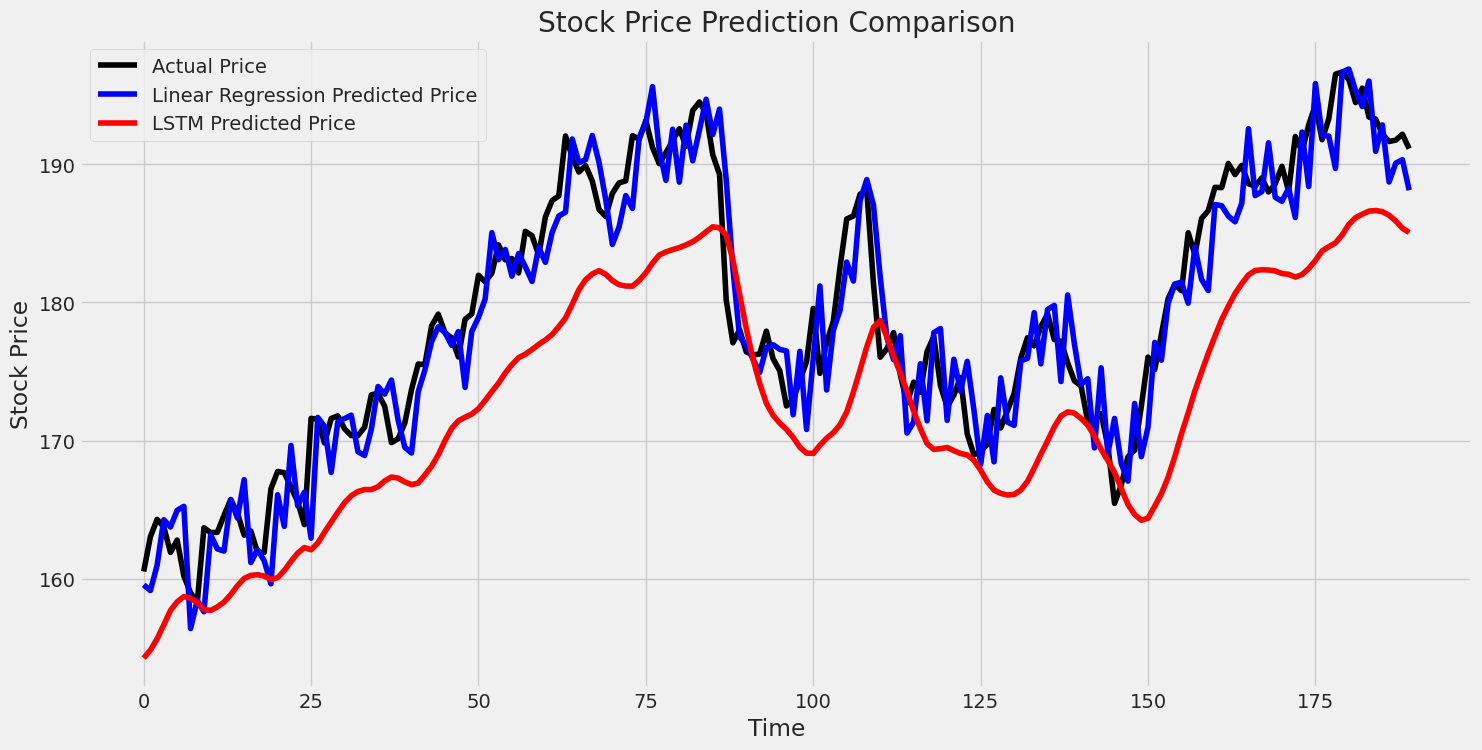

In [76]:
# Plot results
plt.figure(figsize=(16,8))
plt.plot(y_test_actual, color='black', label='Actual Price')
plt.plot(lin_pred_actual, color='blue', label='Linear Regression Predicted Price')
plt.plot(lstm_pred_actual, color='red', label='LSTM Predicted Price')
plt.title('Stock Price Prediction Comparison')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


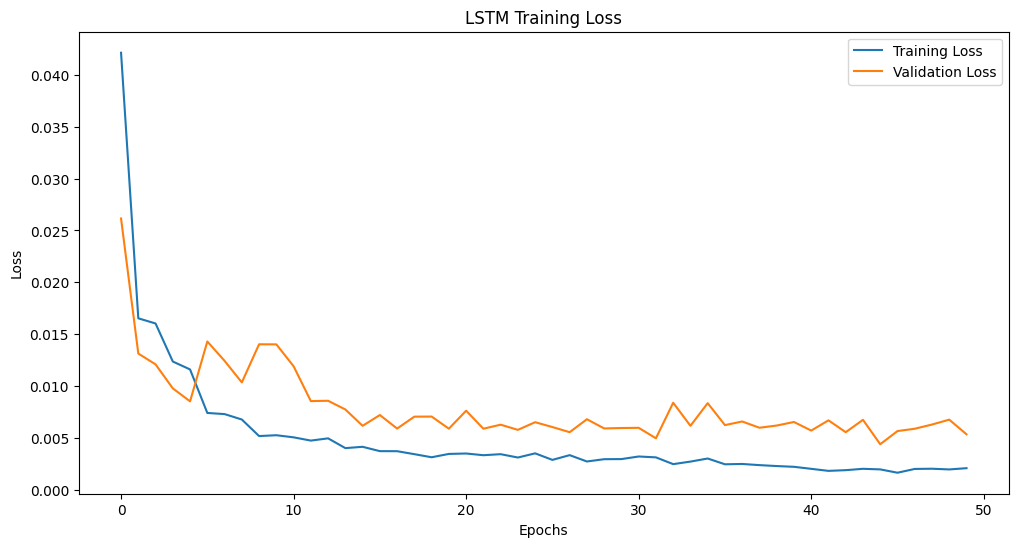

In [102]:
# Plot training loss for LSTM
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()